<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [18]:
# system library
import os
import sys
import json

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve
from yellowbrick.target import ClassBalance

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# linear classifiers
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

# ensemble classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# imbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline as imbmake_pipeline

# over_sampling imbalancer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler

# under_sampling imbalancer
from imblearn.under_sampling import NearMiss 
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours 
from imblearn.under_sampling import CondensedNearestNeighbour


plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

<h6> Datasets loading </h6>

In [19]:
X_train = pd.read_csv('../../data/fma_metadata/X_train_merged.csv', index_col=0)
X_test = pd.read_csv('../../data/fma_metadata/X_test.csv', index_col=0)

y_train = pd.read_csv('../../data/fma_metadata/y_train_merged.csv', index_col=0)
y_test = pd.read_csv('../../data/fma_metadata/y_test.csv', index_col=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

X_train_vt = pd.read_csv('../../data/fma_metadata/X_train_merged_vt.csv', index_col=0)
X_test_vt = pd.read_csv('../../data/fma_metadata/X_test_vt.csv', index_col=0)

print(X_train_vt.shape, X_test_vt.shape)
print(y_train.shape, y_test.shape)

(92834, 55) (10874, 55)
(92834, 1) (10874, 1)
(92834, 28) (10874, 28)
(92834, 1) (10874, 1)


<h6> Global parameters </h6>

In [62]:
n_iter = 10
scoring = 'f1_weighted'
random_state = 42

# test_n_splits = 9
test_n_splits = 3

model = DecisionTreeClassifier(random_state=random_state)
model_name = "DecisionTreeClassifier"

trails_flag = True
v_or_t_flag = "TST"
cmap = plt.cm.Blues
color = "blue"

<h6>Continous, categorical/ordinal column retrieval</h6>

In [21]:
numeric_columns = []  # continous variables
for column_name in X_train.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [22]:
categoric_columns = []  # ordinal or categorical variables
for column_name in X_train.columns:
    if ("track_genre_top" in column_name) or  \
          ("track_date_created_year" in column_name) or \
            ("track_date_created_season" in column_name):
                categoric_columns.append(column_name)
print("categoric_columns", len(categoric_columns))

categoric_columns 18


In [23]:
numeric_columns_vt = set(numeric_columns).intersection(set(X_train_vt.columns))
print("numeric_columns_vt", len(numeric_columns_vt))

numeric_columns_vt 15


In [24]:
categoric_columns_vt = set(categoric_columns).intersection(set(X_train_vt.columns))
print("categoric_columns_vt", len(categoric_columns_vt))

categoric_columns_vt 13


<h6>Define current (filtered) train and test</h6>

In [25]:
X_tr = X_train
y_tr = y_train
X_ts = X_test
y_ts = y_test

X_tr_vt = X_train_vt
X_ts_vt = X_test_vt

print(X_tr.shape, X_ts.shape, X_tr_vt.shape, X_ts_vt.shape)
print(y_tr.shape, y_ts.shape)

(92834, 55) (10874, 55) (92834, 28) (10874, 28)
(92834, 1) (10874, 1)


<h6> Useful functions </h6>

In [26]:
def model_grid(X_tr):
    grid = dict()
    grid['model__criterion'] = ['gini', 'entropy']
    grid['model__max_features'] = [None, 'auto', 'sqrt', 'log2']
    grid['model__max_depth'] = [None] + list(np.arange(1, len(X_tr.columns) + 1))
    # grid['model__min_samples_split'] = [0.1, 0.01, 0.001] # ceil(min_samples_split * n_samples)
    grid['model__min_samples_split'] = [2, 5] + list(range(10, 101, 10))
    # grid['model__min_samples_split'] = list(np.arange(2, 101))
    # grid['model__min_samples_leaf'] = [0.05, 0.005, 0.0005] # ceil(min_samples_split * n_samples)
    grid['model__min_samples_leaf'] = [2, 5] + list(range(10, 101, 10))
    # grid['model__min_samples_leaf'] = list(np.arange(2, 101))
    grid['model__class_weight'] = ['balanced', None]
    return grid

In [27]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_roc(y_ts, y_prob)
    plt.title("%s\'s %s ROC curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_precision_recall_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_precision_recall(y_ts, y_prob)
    plt.title("%s\'s %s Precision-Recall curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_cumulative_gain_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_cumulative_gain(y_ts, y_prob)
    plt.title("%s\'s %s Cumulative Gains curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_lift_curve_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_lift_curve(y_ts, y_prob)
    plt.title("%s\'s %s Lift curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s\'s %s classification report" % (model_name.capitalize(), v_or_t_flag.upper()))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s\'s %s confusion matrix" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_decision_boundary(X_tr, y_tr, scaler, model):
    pca = PCA(n_components=2)
    best_visualisation_scaler = StandardScaler()
    scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
    X = pca.fit_transform(scaled_X_tr)
    # X = pca.fit_transform(X_tr)
    y = y_tr.values.ravel()

    model.fit(X, y)
    plt.figure(figsize=(8, 5))
    fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
    plt.legend(loc='best', framealpha=1, shadow=True, borderpad=1)
    plt.grid(False)
    plt.show()

def spot_errors(test_label, test_pred):  
    spot_errors = []
    label_errors = []
    for i in range(len(test_label)):
        if test_label[i] != test_pred[i]:
            spot_errors.append('darkred')
            label_errors.append("wrong prediction")
        else:
            spot_errors.append('darkgray')
            label_errors.append("correct prediction")
    return spot_errors, label_errors

def classification_visualizer(test_set, test_label, test_pred):
    test_label = test_label.values
    
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
    errors, label_errors = spot_errors(test_label, test_pred)
    labels = [test_label, test_pred, errors]
    titles = ['True Labels', 'Predicted Labels', 'Misclassifications']
    
    for i in range(0, 3):
        axs[i].scatter(test_set[missclassif_column_name1], test_set[missclassif_column_name2], c=labels[i], cmap='cividis')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(missclassif_column_name1, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(missclassif_column_name2, fontdict={'fontsize': 'large'})
        
    plt.suptitle('Visualization of the ' + model_name + ' classifier on the %s' % v_or_t_flag)
    plt.show()
    

def error_visualizer(test_set, test_label, test_pred, column_name1, column_name2):
    test_label = test_label.values
    errors, label_errors = spot_errors(test_label, test_pred)
    
    palette = ['darkgray', 'darkred']
    if errors[0] == 'darkred':
        palette = ['darkred', 'darkgray']
    
    fig = plt.figure(figsize=(5, 6))
    sns.scatterplot(x=test_set[column_name1], y=test_set[column_name2], hue=label_errors, palette=palette)
    plt.title('%s\'s %s misclassifications' % (model_name, v_or_t_flag))
    plt.xlabel(column_name1)
    plt.ylabel(column_name2)

    plt.legend()
    plt.show()

In [28]:
# IMBALANCE PLOT FUNCTIONS
def plot_class_balance(y_tr, x_label):
    if isinstance(y_tr, pd.core.frame.DataFrame):
        y_tr = y_tr.values.ravel()
    
    plt.figure(figsize=(8, 5))
    visualizer = ClassBalance()   # Instantiate the visualizer
    visualizer.fit(y_tr)        # Fit the data to the visualizer
    visualizer.ax.set_xlabel(x_label)
    visualizer.show()        # Finalize and render the figure
    plt.show()

def plot_examples_by_class_label(X_tr, y_tr, best_visualisation_scaler, imbalancer_name):
    # summarize class distribution
    if isinstance(y_tr, pd.core.frame.DataFrame):
        y = y_tr.values.ravel()
    else:
        y = y_tr
    counter = Counter(y)
    print(counter)
    
    pca = PCA(n_components=2)
    scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
    X = pca.fit_transform(scaled_X_tr)
    # X = pca.fit_transform(X_tr)

    model.fit(X, y)
    plt.figure(figsize=(8, 5))
    for label, _ in counter.items():
        row_ix = np.where(y == label)[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label), s=15)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    if imbalancer_name != "":
        plt.title("%s's %s %s resampling" % (model_name, v_or_t_flag, imbalancer_name))
    else:
        plt.title("%s original class labels" % (v_or_t_flag))
    plt.legend(loc='best', framealpha=1, shadow=True, borderpad=1)
    plt.grid(False)
    plt.show()

In [29]:
def get_best_features_grid_cv(X_tr, y_tr, results, key):
    
    if key == 'anova':
        best_k = results.best_params_['anova__k']
        select_k_best = SelectKBest(score_func=f_classif, k=best_k)
        fit = select_k_best.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.scores_)
        df_columns = pd.DataFrame(X_tr.columns)
    elif key == 'rfe':
        best_k = results.best_params_['rfe__n_features_to_select']
        estimator = results.best_params_['rfe__estimator']
        select_rfe = RFE(estimator=estimator, n_features_to_select=best_k)  # best_k=estimator
        fit = select_rfe.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.ranking_)
    else:
        print("wrong key=%s" % key)
        sys.exit(-1)
  
    df_columns = pd.DataFrame(X_tr.columns)
    feature_scores = pd.concat([df_columns, df_scores],axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    
    if trails_flag == False:
        # plot feature importance
        fig = plt.figure(figsize=(8, 10))
        sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                                order=ordered_k_feature_scores.features)
        plt.grid(False)
        plt.title("%s's %s feature importance using %s" % (model_name, v_or_t_flag,  key.upper()))
        plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)

    return best_features, best_features_scores

In [30]:
def get_feature_importances_or_coef(X_tr, y_tr, tuned_model):

    try:
        df_scores = pd.DataFrame(tuned_model.feature_importances_)
        best_k = tuned_model.n_features_
    except:
        try:
            df_scores = pd.DataFrame(tuned_model.coef_)

            best_k = len([x for x in list(df_scores.values)])
        except:
            print("Wrong curr_model's retrieval feature importance")
            sys.exit(-1)

    df_columns = pd.DataFrame(X_tr.columns)   
    feature_scores = pd.concat([df_columns, df_scores], axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    
    if trails_flag == False:
        # plot feature importance
        fig = plt.figure(figsize=(8, 10))
        sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                                order=ordered_k_feature_scores.features)
        plt.grid(False)
        plt.title("%s's %s feature importance" % (model_name, v_or_t_flag))
        plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)


    return best_features, best_features_scores

In [31]:
def get_tuned_model(X_tr, y_tr, params):
    
    if isinstance(y_tr, pd.core.frame.DataFrame):
        y_tr = y_tr.values.ravel()
    
    model_params = list(model_grid(X_tr).keys())
    try:
        scaler = params['scaler']
        # scale data
        X_tr = scaler.fit_transform(X_tr.values)
    except KeyError:
        pass
    
    # retrieve best hyperameters
    tmp_model_hyperparameters = dict((k, params[k]) for k in model_params if k in params)
    model_hyperparameters = {}
    for key, value in tmp_model_hyperparameters.items():
        key = key.split('model__')[1].replace("'", "")
        model_hyperparameters[key] = value
        
    tuned_model =  model.set_params(**model_hyperparameters)
    tuned_model.fit(X_tr, y_tr)
    return tuned_model

In [32]:
def get_X_and_y_sampled(X_tr, y_tr, params):
    
    imbalancer_params = dict((k.split("__")[1].replace("'", ""), v) for k, v in params.items() 
                             if 'imbalancer' in k)
    try:
        scaler = params['scaler']
        # scale data
        X_tr = scaler.fit_transform(X_tr.values)
    except KeyError:
        pass
        
    tuned_imbalancer =  imbalancer.set_params(**imbalancer_params)
    X_tr_resampled, y_tr_resampled = tuned_imbalancer.fit_resample(X_tr, y_tr.values.ravel())
    return X_tr_resampled, y_tr_resampled

In [33]:
def imbalanced_grid_search(X_tr, y_tr, X_ts, y_ts, grid, imbalancer, imbalancer_name,
                                                           scaler_flag, feature_filter_key, feature_flag):
    
    # define the evaluation method
    cv = StratifiedKFold(n_splits=test_n_splits)

    # construct the pipeline to evaluate
    # scaler = RobustScaler()
    steps = [('imbalancer', imbalancer), ('model', model)]
        
    if feature_filter_key == 'anova':
        anova = SelectKBest(score_func=f_classif)
        steps.insert(0, ('anova', anova))
        grid['anova__k'] = [i+1 for i in range(X_tr.shape[1])]
    elif feature_filter_key == 'rfe':
        rfe = RFE(estimator=DecisionTreeClassifier())
        steps.insert(0, ('rfe', rfe))
        grid['rfe__estimator'] = [DecisionTreeClassifier(), LogisticRegression(max_iter=10000)]
        grid['rfe__n_features_to_select'] = [i+1 for i in range(X_tr.shape[1])]
    
    if scaler_flag:
        steps.insert(0, ('scaler', None))
        grid['scaler'] = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()]
    
    # define the pipeline to evaluate
    pipeline = ImbPipeline(steps=steps)
    
    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=None, cv=cv, verbose=1)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=None, 
                                n_iter=n_iter, cv=cv, verbose=1, refit=scoring, random_state=random_state)
    
    # perform the search
    results = search.fit(X_tr.values, y_tr.values.ravel())
    
    # summarize best
    score = results.best_score_
    params = results.best_params_
    print('Best Mean F1_weighted: %.3f ' % score)
    print('Best Config: %s ' % params)
    
    # perform classification
    y_pred = search.predict(X_ts.values)
    y_prob = search.predict_proba(X_ts.values)
    
    # retrieve the tuned imbalancer
    X_tr_resampled, y_tr_resampled =  get_X_and_y_sampled(X_tr, y_tr, params)
    # turning resampled traing again in a DataFrame
    X_tr_resampled = pd.DataFrame(X_tr_resampled)
    X_tr_resampled.columns = list(X_tr.columns)
    y_tr_resampled = pd.DataFrame(y_tr_resampled)
    y_tr_resampled.columns = list(y_tr.columns)
    
    best_features, best_features_scores = [], []
    if feature_filter_key != "":
        best_features, best_features_scores = get_best_features_grid_cv(X_tr_resampled, 
                                                                        y_tr_resampled, 
                                                                        results, 
                                                                        feature_filter_key)
        X_tr = X_tr[best_features]
        X_tr_resampled = X_tr_resampled[best_features]
    
    # retrieve the tuned model
    tuned_model = get_tuned_model(X_tr_resampled, y_tr_resampled, params)
    if tuned_model !=  pipeline['model']:
        print("Difference in tuned model and pipeline")
        print("tuned_model", tuned_model)
        print("pipe", pipeline['model'])
        # print("estimator", results.estimator)
        sys.exit(-1)
    
    # plots
    if (feature_flag) and (feature_filter_key == ""):
        best_features, best_features_scores = get_feature_importances_or_coef(X_tr_resampled, 
                                                                              y_tr_resampled,
                                                                              tuned_model)
    elif (feature_flag) and (feature_filter_key != ""):
        _, _ = get_feature_importances_or_coef(X_tr_resampled, y_tr_resampled, tuned_model)
 
    cm = confusion_matrix(y_ts, y_pred)
    plot_confusion_matrix(cm, results.classes_, True)
    plot_classification_report(y_ts, y_pred)
    
    plot_roc_curve(y_ts, y_prob)
    if trails_flag == False:
        plot_precision_recall_curve(y_ts, y_prob)
        plot_cumulative_gain_curve(y_ts, y_prob)
        plot_lift_curve_curve(y_ts, y_prob)

        plot_decision_boundary(X_tr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
        # plot_learning_curve(X_tr, y_tr, tuned_model)
        # error_visualizer(not_scale_X_ts, y_ts, y_pred, 'chroma_cens_02', 'track_duration')
    
    # imbalance plot
    plot_class_balance(y_tr_resampled, imbalancer_name)
    # plot_examples_by_class_label(X_tr_resampled, y_tr_resampled, StandardScaler(), imbalancer_name)
    # plot_examples_by_class_label(X_tr_resampled, y_tr_resampled, RobustScaler(), imbalancer_name)
    
    return params, tuned_model, y_pred, y_prob, best_features

<h1>Imbalanced problem</h1>

Imbalanced datasets are those where there is a severe skew in the class distribution, such as
1:100 or 1:1000 examples in the minority class to the majority class. This bias in the training
dataset can influence many machine learning algorithms, leading some to ignore the minority
class entirely.

We will address imbalanced datasets using three aproaces:
1. **Oversampling**: to oversample the minority class, using **RandomOversampling, SMOTE, Borderline-SMOTE, SVSMOTE and ADASYN**;
2. **Undersampling**: to undersample the majority class, using **RandomUndersampling, Near Miss, Condensed Nearest Neighbour, Tomek Link and Edited Nearest Neighbors**.

<b><font color="red">Since many Oversampling and Undersampling methods use the notion of distance or an intrisec KNN classifiere, we will use only continous features while performing imbalancing.</font></b>

<h6>Original data imbalance</h6>

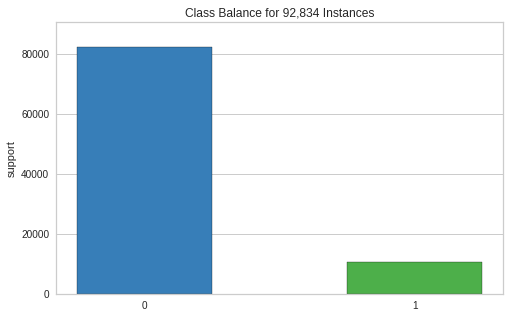

Counter({0: 82389, 1: 10445})


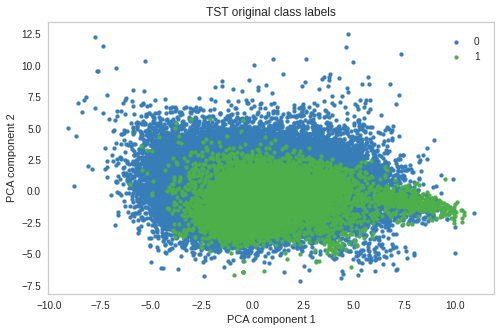

Counter({0: 82389, 1: 10445})


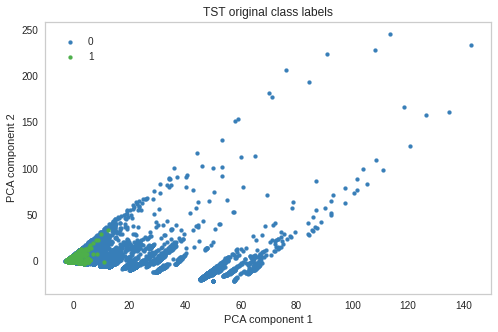

In [185]:
plot_class_balance(y_train, "")

plot_examples_by_class_label(X_train, y_train, StandardScaler(), "")
plot_examples_by_class_label(X_train, y_train, RobustScaler(), "")

<h1>Oversampling</h1>

<h2>RandomOversampling</h2>

One approach to addressing the problem of class imbalance is to randomly sample the
training dataset. The two main approaches to randomly sampling an imbalanced dataset are:
- **Random oversampling** involves randomly selecting examples from the minority class, with
replacement, and adding them to the training dataset;
- Random undersampling involves randomly selecting examples from the majority class and deleting them from the training dataset.

Both approaches can be repeated until the desired class distribution is achieved in the
training dataset, such as an equal split across the classes. They are referred to as **naive sampling**
methods because they assume nothing about the data and no heuristics are used.

<font color="green">PROS: This technique can be effective for those machine learning algorithms that are affected by a skewed distribution and where multiple duplicate examples for a given class can influence the
fit of the model. This might include algorithms that iteratively learn coefficients, like artificial
    neural networks that use stochastic gradient descent. It can also affect models that seek good
    splits of the data, such as support vector machines and decision trees. The increase in the number of examples for the minority class, especially if the class skew was severe, can also result in a marked increase in
the computational cost when fitting the model,
</font>

<font color="red">CONS: In some cases, seeking a balanced
distribution for a severely imbalanced dataset can cause affected algorithms to overfit the
minority class, leading to increased generalization error. The effect can be better performance
on the training dataset, but worse performance on the holdout or test dataset.
</font>

**Default parameters**:
- sampling_strategy='auto',   # resample all classes but the majority class
- random_state=None, 
- shrinkage=None  #  shrinkage applied to the covariance matrix


**Tuned parameters**:
- sampling_strategy = np.arange(0.1, 1.1, 0.1)*  
- random_state=42, 

*number of samples in the minority class after resampling / number of samples in the majority class => desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling

In [186]:
def random_oversampler_grid(X_tr, y_tr):
    grid = model_grid(X_tr)
    grid['imbalancer__sampling_strategy'] = list(np.arange(0.1, 1.1, 0.1))
    return grid

In [187]:
imbalancer_name = 'RandomOverSampler'
imbalancer = RandomOverSampler(random_state=random_state)

<h6>Plain model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.660 
Best Config: {'scaler': RobustScaler(), 'model__min_samples_split': 40, 'model__min_samples_leaf': 30, 'model__max_features': 'sqrt', 'model__max_depth': 19, 'model__criterion': 'entropy', 'model__class_weight': None, 'imbalancer__sampling_strategy': 0.8} 


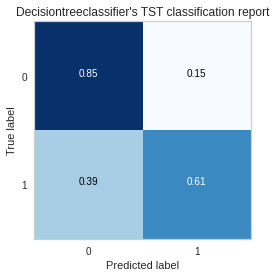

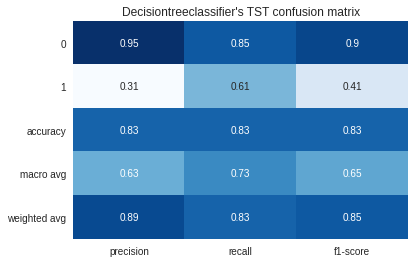

<Figure size 576x360 with 0 Axes>

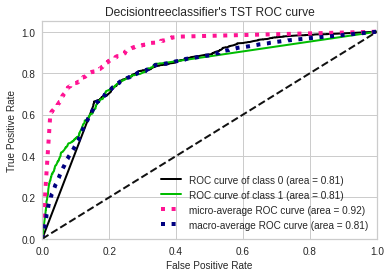

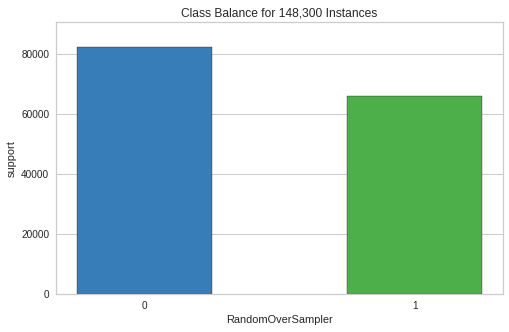

In [188]:
random_oversampler_params, random_oversampler_tuned_model, random_oversampler_y_pred, \
            random_oversampler_y_prob, random_oversampler_best_features = \
                                                    imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=random_oversampler_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

<h6>ANOVA model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.682 
Best Config: {'scaler': RobustScaler(), 'model__min_samples_split': 70, 'model__min_samples_leaf': 60, 'model__max_features': 'auto', 'model__max_depth': 18, 'model__criterion': 'entropy', 'model__class_weight': 'balanced', 'imbalancer__sampling_strategy': 0.8, 'anova__k': 39} 


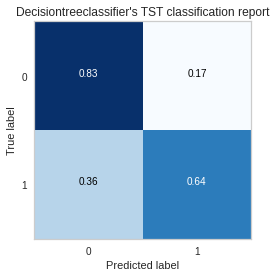

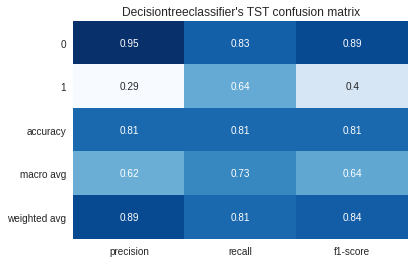

<Figure size 576x360 with 0 Axes>

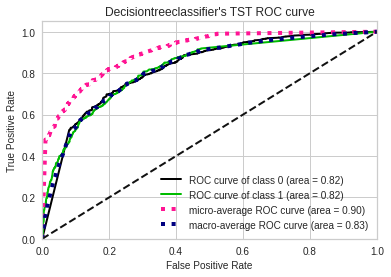

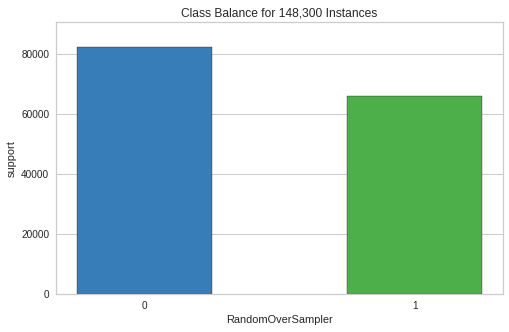

In [189]:
random_oversampler_params_anova, random_oversampler_tuned_model_anova, random_oversampler_y_pred_anova, \
                        random_oversampler_y_prob_anova, random_oversampler_best_features_anova = \
                                                    imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=random_oversampler_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="anova", 
                                                                           feature_flag=True)

<h6>RFE model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.835 
Best Config: {'scaler': RobustScaler(), 'rfe__n_features_to_select': 4, 'rfe__estimator': LogisticRegression(max_iter=10000), 'model__min_samples_split': 100, 'model__min_samples_leaf': 100, 'model__max_features': 'sqrt', 'model__max_depth': 4, 'model__criterion': 'gini', 'model__class_weight': None, 'imbalancer__sampling_strategy': 0.4} 


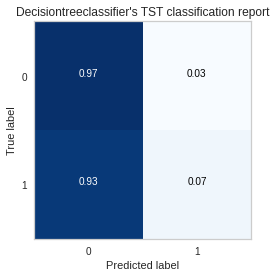

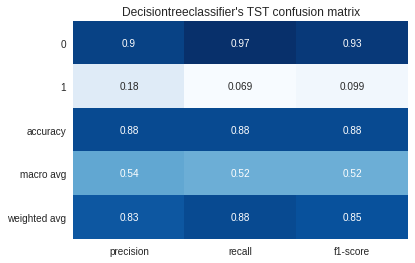

<Figure size 576x360 with 0 Axes>

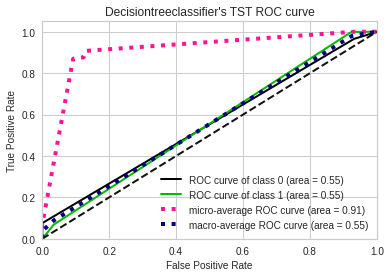

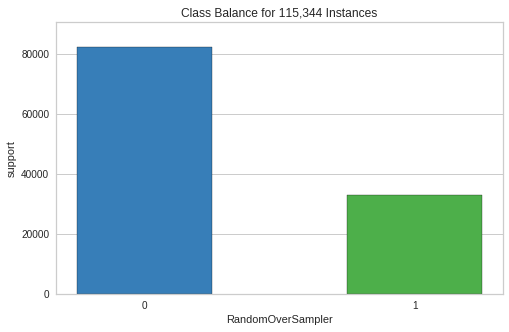

In [190]:
random_oversampler_params_rfe, random_oversampler_tuned_model_rfe, random_oversampler_y_pred_rfe, \
                        random_oversampler_y_prob_rfe, random_oversampler_best_features_rfe = \
                                                    imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=random_oversampler_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="rfe", 
                                                                           feature_flag=True)

<h6>VarianceThreshold model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.745 
Best Config: {'scaler': RobustScaler(), 'model__min_samples_split': 40, 'model__min_samples_leaf': 80, 'model__max_features': 'sqrt', 'model__max_depth': 9, 'model__criterion': 'entropy', 'model__class_weight': 'balanced', 'imbalancer__sampling_strategy': 0.7000000000000001} 


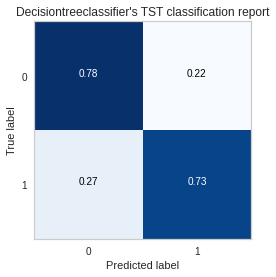

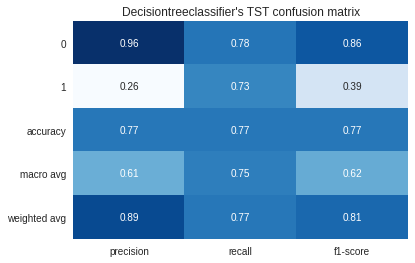

<Figure size 576x360 with 0 Axes>

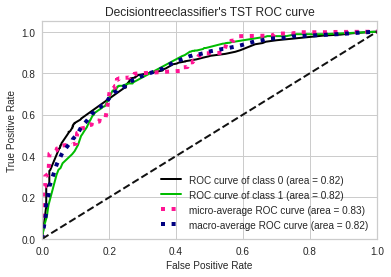

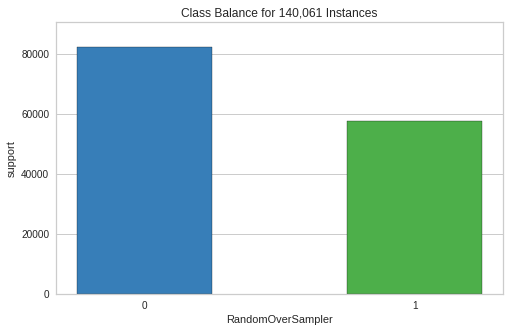

In [191]:
random_oversampler_params_vt, random_oversampler_tuned_model_vt, random_oversampler_y_pred_vt, \
                        random_oversampler_y_prob_vt, random_oversampler_best_features_vt = \
                                                    imbalanced_grid_search(
                                                                           X_tr=X_tr_vt, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts_vt, 
                                                                           y_ts=y_ts, 
                                                                           grid=random_oversampler_grid(X_tr_vt, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

<h2>SMOTE</h2>

The simplest oversampling approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or **SMOTE** for short.

<i>Specifically, a random example from the minority class is first chosen. Then k of the nearest
neighbors for that example are found (typically k = 5). A randomly selected neighbor is chosen
and a synthetic example is created at a randomly selected point between the two examples in
feature space. This procedure can be used to create as many synthetic examples for the minority class as
are required.
</i>

<font color="green">PROS: The approach is effective because new synthetic examples from the minority class are created
that are plausible, that is, are relatively close in feature space to existing examples from the
minority class.
</font>

<font color="red">CONS: A general downside of the approach is that synthetic examples are created without considering
the majority class, possibly resulting in ambiguous examples if there is a strong overlap for the
classes.
</font>

**Default parameters**:
- sampling_strategy='auto',   # resample all classes but the majority class
- random_state=None, 
- k_neighbors=5, 
- n_jobs=None


**Tuned parameters**:
- sampling_strategy = np.arange(0.1, 1.1, 0.1)*  
- random_state=42, 
- k_neighbors= range(1, sqrt(n_records)*2), 
- n_jobs=None

*number of samples in the minority class after resampling / number of samples in the majority class => desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling

In [192]:
def smote_grid(X_tr, y_tr):
    grid = model_grid(X_tr)
    sqrt_records = round(math.sqrt(X_tr.shape[0])) 
    grid['imbalancer__k_neighbors'] = list(range(1, sqrt_records*2))
    grid['imbalancer__sampling_strategy'] = list(np.arange(0.1, 1.1, 0.1))
    return grid

In [193]:
imbalancer_name = 'SMOTE'
imbalancer = SMOTE(random_state=random_state, n_jobs=None)

<h6>Plain model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.838 
Best Config: {'scaler': StandardScaler(), 'model__min_samples_split': 90, 'model__min_samples_leaf': 90, 'model__max_features': 'log2', 'model__max_depth': 29, 'model__criterion': 'entropy', 'model__class_weight': None, 'imbalancer__sampling_strategy': 0.2, 'imbalancer__k_neighbors': 383} 


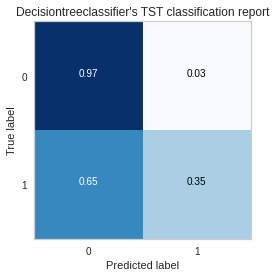

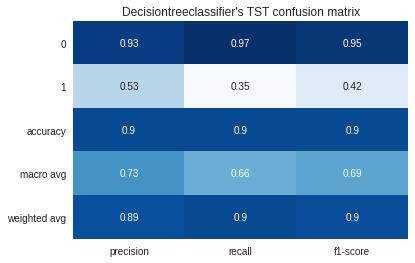

<Figure size 576x360 with 0 Axes>

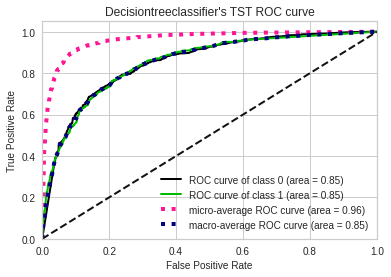

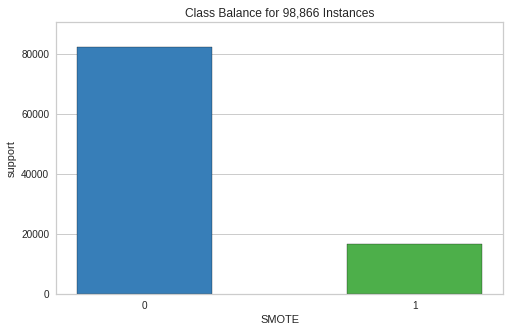

In [194]:
smote_params, smote_tuned_model, smote_y_pred, smote_y_prob, smote_best_features = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=smote_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

<h6>ANOVA model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.765 
Best Config: {'scaler': MaxAbsScaler(), 'model__min_samples_split': 50, 'model__min_samples_leaf': 90, 'model__max_features': 'sqrt', 'model__max_depth': 42, 'model__criterion': 'entropy', 'model__class_weight': 'balanced', 'imbalancer__sampling_strategy': 0.8, 'imbalancer__k_neighbors': 327, 'anova__k': 53} 


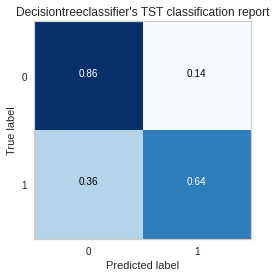

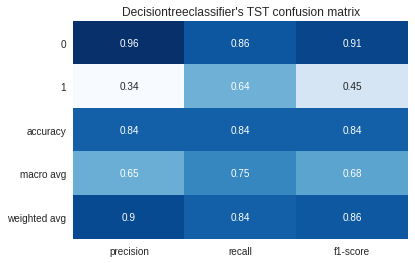

<Figure size 576x360 with 0 Axes>

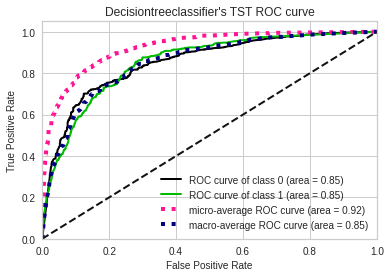

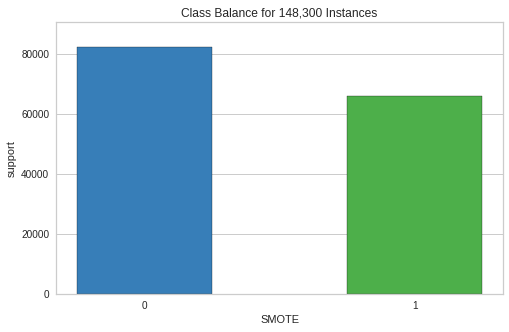

In [195]:
smote_params_anova, smote_tuned_model_anova, smote_y_pred_anova, smote_y_prob_anova, \
                                        smote_best_features_anova = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=smote_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="anova", 
                                                                           feature_flag=True)

<h6>RFE model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.703 
Best Config: {'scaler': MinMaxScaler(), 'rfe__n_features_to_select': 24, 'rfe__estimator': DecisionTreeClassifier(), 'model__min_samples_split': 80, 'model__min_samples_leaf': 20, 'model__max_features': 'auto', 'model__max_depth': 4, 'model__criterion': 'gini', 'model__class_weight': 'balanced', 'imbalancer__sampling_strategy': 0.4, 'imbalancer__k_neighbors': 160} 


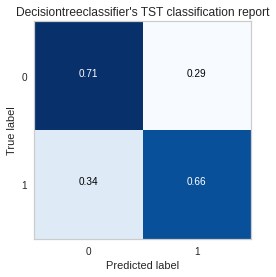

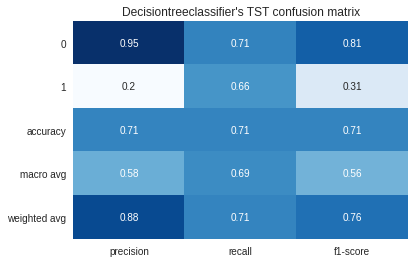

<Figure size 576x360 with 0 Axes>

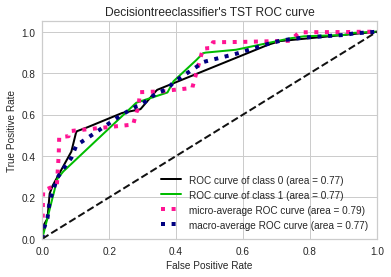

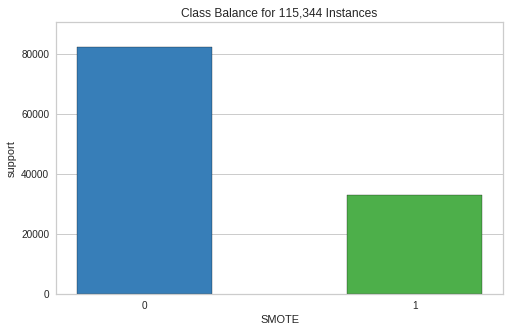

In [196]:
smote_params_rfe, smote_tuned_model_rfe, smote_y_pred_rfe, smote_y_prob_rfe, \
                        smote_best_features_rfe = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=smote_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="rfe", 
                                                                           feature_flag=True)

<h6>VarianceThreshold model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.720 
Best Config: {'scaler': StandardScaler(), 'model__min_samples_split': 40, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': 12, 'model__criterion': 'gini', 'model__class_weight': None, 'imbalancer__sampling_strategy': 0.7000000000000001, 'imbalancer__k_neighbors': 161} 


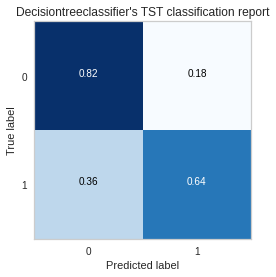

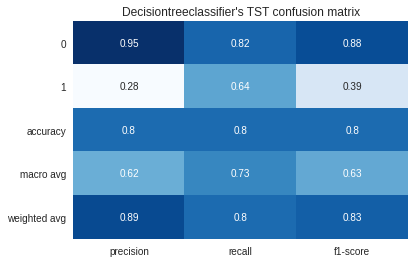

<Figure size 576x360 with 0 Axes>

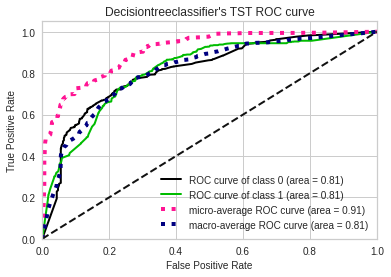

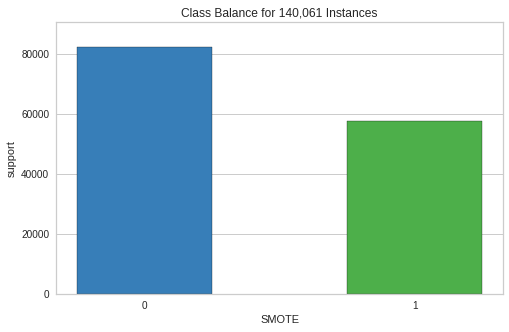

In [197]:
smote_params_vt, smote_tuned_model_vt, smote_y_pred_vt, smote_y_prob_vt, \
                            smote_best_features_vt = imbalanced_grid_search(
                                                                           X_tr=X_tr_vt, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts_vt, 
                                                                           y_ts=y_ts, 
                                                                           grid=smote_grid(X_tr_vt, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

<h2>Borderline-SMOTE</h2>

A popular extension to SMOTE involves selecting those instances of the minority class that are
misclassified, such as with a k-nearest neighbor classification model. We can then oversample
just those difficult instances, providing more resolution only where it may be required.

These examples that are misclassified are likely ambiguous and on the edge or border of the
decision boundary where class membership may overlap. The
authors also describe a version of the method that also oversampled the majority class for those
examples that cause a misclassification of borderline instances in the minority class. This is
referred to as Borderline-SMOTE1, whereas the oversampling of just the borderline cases in
minority class is referred to as **Borderline-SMOTE2**.

The simplest oversampling approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or **SMOTE** for short.

<i>Specifically, a random example from the minority class is first chosen. Then k of the nearest
neighbors for that example are found (typically k = 5). A randomly selected neighbor is chosen
and a synthetic example is created at a randomly selected point between the two examples in
feature space. This procedure can be used to create as many synthetic examples for the minority class as
are required.
</i>

<font color="green">PROS: Instead of generating new synthetic examples for the minority class blindly,
we would expect the Borderline-SMOTE method to only create synthetic examples along the
decision boundary between the two classes.
</font>

**Default parameters**:
- sampling_strategy='auto',   # resample all classes but the majority class
- random_state=None, 
- k_neighbors=5, 
- n_jobs=None,
- m_neighbors=10, 
- kind='borderline-1'


**Tuned parameters**:
- sampling_strategy = np.arange(0.1, 1.1, 0.1)*  
- random_state=42, 
- k_neighbors = range(1, sqrt(n_records)*2), 
- n_jobs=None
- m_neighbors= {i*2 | i € k_neighbors}, # number of nearest neighbours to use to determine if a minority sample is in danger
- kind=['borderline-1' , 'borderline-2']  # oversample majority&minority or minority border classes

*number of samples in the minority class after resampling / number of samples in the majority class => desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling

In [198]:
def borderline_smote_grid(X_tr, y_tr):
    grid = model_grid(X_tr)
    sqrt_records = round(math.sqrt(X_tr.shape[0])) 
    k_neighbors = list(range(1, sqrt_records*2))
    m_neighbors = [x*2 for x in k_neighbors]
    grid['imbalancer__k_neighbors'] = k_neighbors
    grid['imbalancer__m_neighbors'] = m_neighbors
    grid['imbalancer__sampling_strategy'] = list(np.arange(0.1, 1.1, 0.1))
    grid['imbalancer__kind'] = ['borderline-1' , 'borderline-2']
    return grid

In [199]:
imbalancer_name = 'BorderlineSMOTE'
imbalancer = BorderlineSMOTE(random_state=random_state, n_jobs=None)

<h6>Plain model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.812 
Best Config: {'scaler': StandardScaler(), 'model__min_samples_split': 70, 'model__min_samples_leaf': 90, 'model__max_features': 'sqrt', 'model__max_depth': 2, 'model__criterion': 'entropy', 'model__class_weight': None, 'imbalancer__sampling_strategy': 0.4, 'imbalancer__m_neighbors': 1078, 'imbalancer__kind': 'borderline-1', 'imbalancer__k_neighbors': 454} 


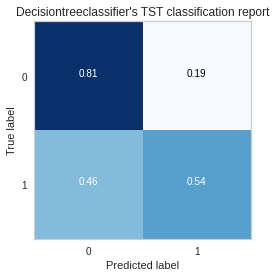

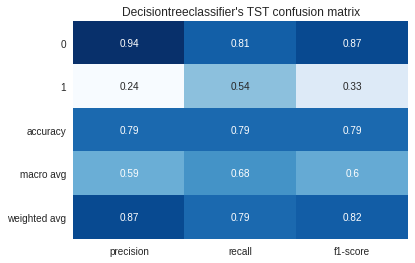

<Figure size 576x360 with 0 Axes>

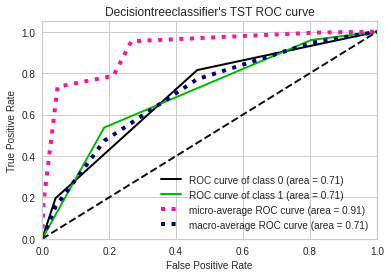

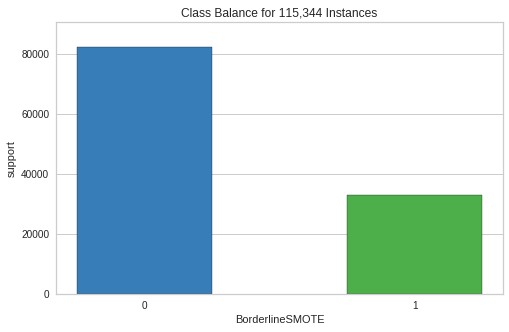

In [200]:
borderline_smote_params, borderline_smote_tuned_model, borderline_smote_y_pred, borderline_smote_y_prob, borderline_smote_best_features = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=borderline_smote_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

<h6>ANOVA model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.729 
Best Config: {'scaler': MinMaxScaler(), 'model__min_samples_split': 40, 'model__min_samples_leaf': 50, 'model__max_features': 'auto', 'model__max_depth': 2, 'model__criterion': 'entropy', 'model__class_weight': 'balanced', 'imbalancer__sampling_strategy': 0.8, 'imbalancer__m_neighbors': 390, 'imbalancer__kind': 'borderline-2', 'imbalancer__k_neighbors': 576, 'anova__k': 53} 


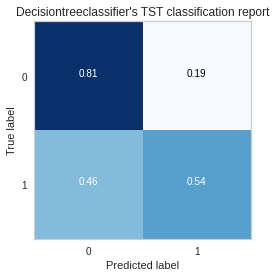

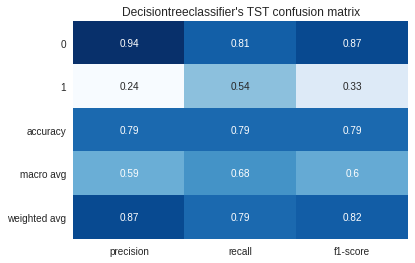

<Figure size 576x360 with 0 Axes>

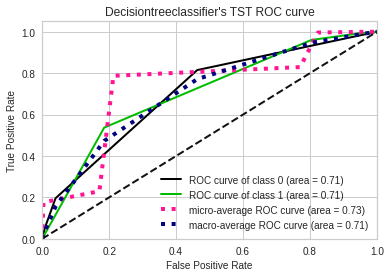

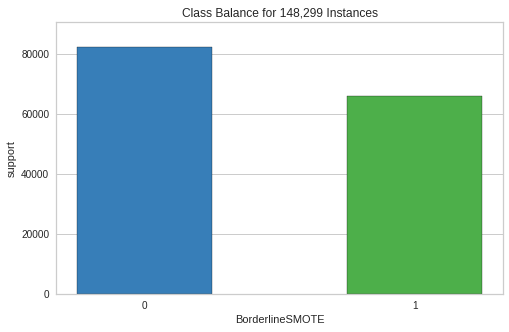

In [201]:
borderline_smote_params_anova, borderline_smote_tuned_model_anova, borderline_smote_y_pred_anova, borderline_smote_y_prob_anova, \
                                        borderline_smote_best_features_anova = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=borderline_smote_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="anova", 
                                                                           feature_flag=True)

<h6>RFE model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.694 
Best Config: {'scaler': StandardScaler(), 'rfe__n_features_to_select': 39, 'rfe__estimator': LogisticRegression(max_iter=10000), 'model__min_samples_split': 40, 'model__min_samples_leaf': 30, 'model__max_features': 'log2', 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced', 'imbalancer__sampling_strategy': 0.8, 'imbalancer__m_neighbors': 836, 'imbalancer__kind': 'borderline-1', 'imbalancer__k_neighbors': 6} 


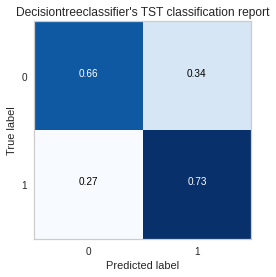

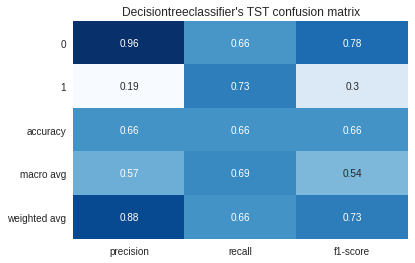

<Figure size 576x360 with 0 Axes>

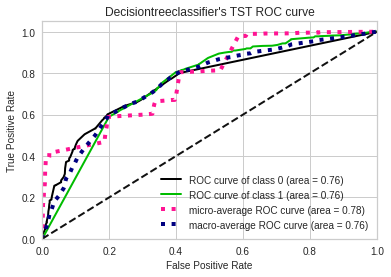

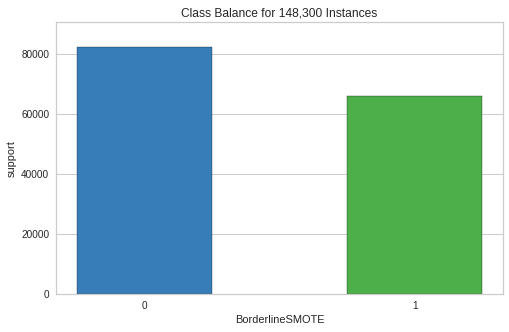

In [202]:
borderline_smote_params_rfe, borderline_smote_tuned_model_rfe, borderline_smote_y_pred_rfe, borderline_smote_y_prob_rfe, \
                        borderline_smote_best_features_rfe = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=borderline_smote_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="rfe", 
                                                                           feature_flag=True)

<h6>VarianceThreshold model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.741 
Best Config: {'scaler': MinMaxScaler(), 'model__min_samples_split': 5, 'model__min_samples_leaf': 40, 'model__max_features': 'sqrt', 'model__max_depth': 8, 'model__criterion': 'gini', 'model__class_weight': 'balanced', 'imbalancer__sampling_strategy': 0.5, 'imbalancer__m_neighbors': 554, 'imbalancer__kind': 'borderline-1', 'imbalancer__k_neighbors': 116} 


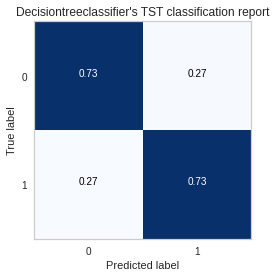

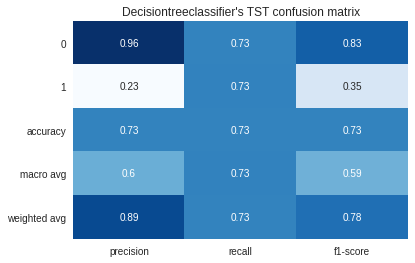

<Figure size 576x360 with 0 Axes>

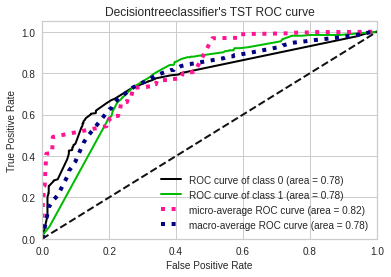

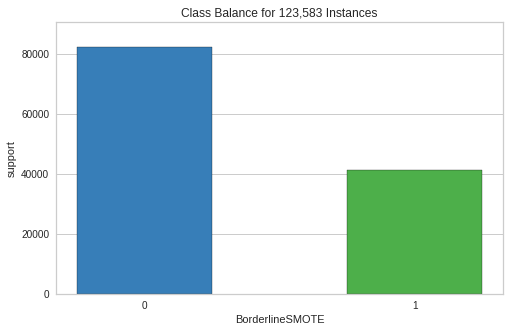

In [203]:
borderline_smote_params_vt, borderline_smote_tuned_model_vt, borderline_smote_y_pred_vt, borderline_smote_y_prob_vt, \
                            borderline_smote_best_features_vt = imbalanced_grid_search(
                                                                           X_tr=X_tr_vt, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts_vt, 
                                                                           y_ts=y_ts, 
                                                                           grid=borderline_smote_grid(X_tr_vt, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

<h2>SVM-SMOTE</h2>

Using an alternative to Borderline-SMOTE where a SVM algorithm
is used instead of a KNN to identify misclassified examples on the decision boundary. A SVM is used to locate the decision boundary defined by the support vectors and examples in the minority class that are close to the support vectors become the focus for generating synthetic examples.

<font color="green"> PROS:In addition to using an SVM, the technique attempts to select regions where there are fewer
examples of the majority class and tries to extrapolate towards the class boundary.</font>



**Default parameters**:
- sampling_strategy='auto',   # resample all classes but the majority class
- random_state=None, 
- k_neighbors=5, 
- n_jobs=None,
- m_neighbors=10, 
- svm_estimator=None  # use default SVM
- out_step=0.5


**Tuned parameters**:
- sampling_strategy = np.arange(0.1, 1.1, 0.1)*  
- random_state=42, 
- k_neighbors = range(1, sqrt(n_records)*2), 
- n_jobs=None
- m_neighbors= {i*2 | i € k_neighbors}, # number of nearest neighbours to use to determine if a minority sample is in danger

*number of samples in the minority class after resampling / number of samples in the majority class => desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling

In [204]:
def svm_smote_grid(X_tr, y_tr):
    grid = model_grid(X_tr)
    sqrt_records = round(math.sqrt(X_tr.shape[0])) 
    k_neighbors = list(range(1, sqrt_records*2))
    m_neighbors = [x*2 for x in k_neighbors]
    grid['imbalancer__k_neighbors'] = k_neighbors
    grid['imbalancer__m_neighbors'] = m_neighbors
    grid['imbalancer__sampling_strategy'] = list(np.arange(0.1, 1.1, 0.1))
    return grid

In [205]:
imbalancer_name = 'SVMSMOTE'
imbalancer = SVMSMOTE(random_state=random_state, n_jobs=None)

<h6>Plain model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.835 
Best Config: {'scaler': StandardScaler(), 'model__min_samples_split': 2, 'model__min_samples_leaf': 30, 'model__max_features': 'log2', 'model__max_depth': 1, 'model__criterion': 'gini', 'model__class_weight': None, 'imbalancer__sampling_strategy': 0.4, 'imbalancer__m_neighbors': 284, 'imbalancer__k_neighbors': 208} 


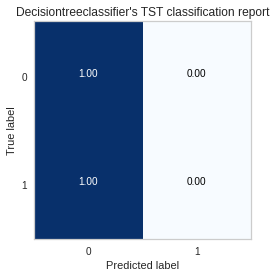

/home/alexandra/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


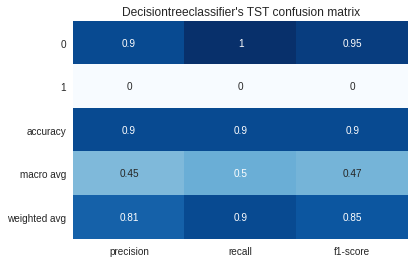

<Figure size 576x360 with 0 Axes>

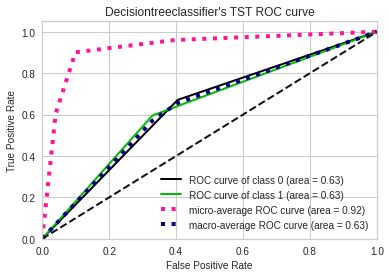

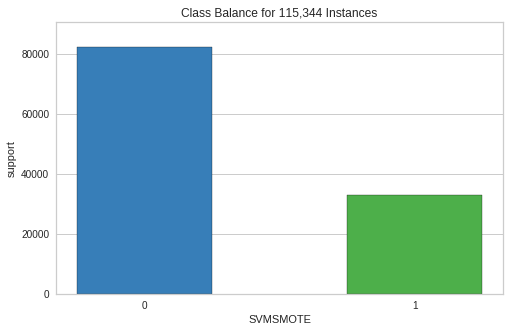

In [206]:
svm_smote_params, svm_smote_tuned_model, svm_smote_y_pred, svm_smote_y_prob, svm_smote_best_features = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=svm_smote_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

<h6>ANOVA model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.746 
Best Config: {'scaler': StandardScaler(), 'model__min_samples_split': 70, 'model__min_samples_leaf': 50, 'model__max_features': 'auto', 'model__max_depth': 29, 'model__criterion': 'entropy', 'model__class_weight': 'balanced', 'imbalancer__sampling_strategy': 0.2, 'imbalancer__m_neighbors': 540, 'imbalancer__k_neighbors': 582, 'anova__k': 36} 


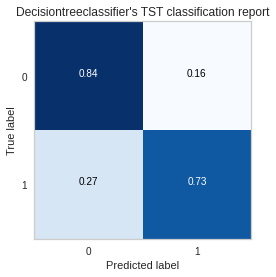

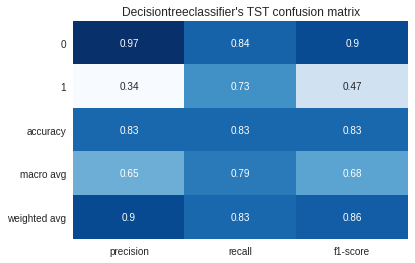

<Figure size 576x360 with 0 Axes>

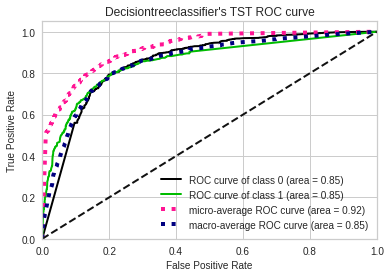

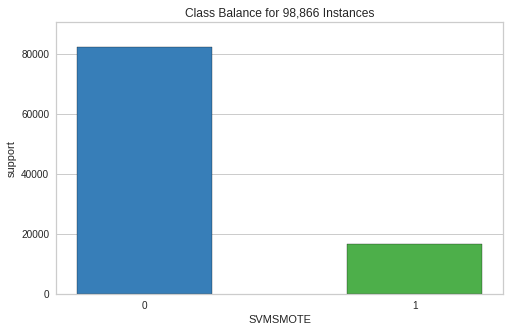

In [207]:
svm_smote_params_anova, svm_smote_tuned_model_anova, svm_smote_y_pred_anova, svm_smote_y_prob_anova, \
                                        svm_smote_best_features_anova = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=svm_smote_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="anova", 
                                                                           feature_flag=True)

<h6>RFE model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.835 
Best Config: {'scaler': StandardScaler(), 'rfe__n_features_to_select': 34, 'rfe__estimator': DecisionTreeClassifier(), 'model__min_samples_split': 10, 'model__min_samples_leaf': 60, 'model__max_features': 'log2', 'model__max_depth': 3, 'model__criterion': 'gini', 'model__class_weight': None, 'imbalancer__sampling_strategy': 0.2, 'imbalancer__m_neighbors': 398, 'imbalancer__k_neighbors': 210} 


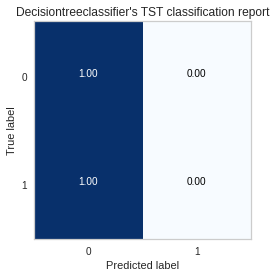

/home/alexandra/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


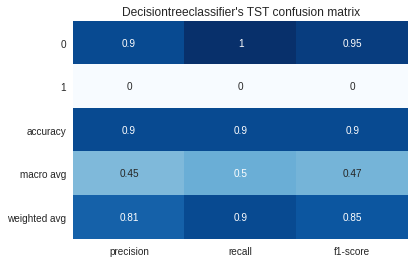

<Figure size 576x360 with 0 Axes>

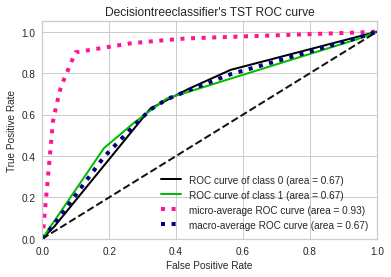

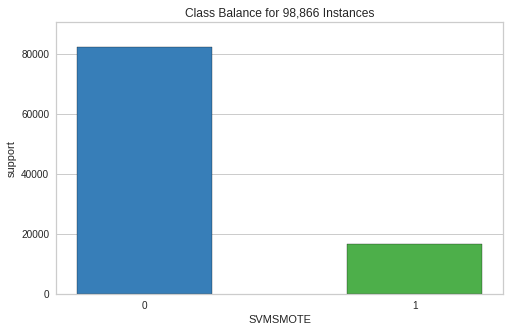

In [208]:
svm_smote_params_rfe, svm_smote_tuned_model_rfe, svm_smote_y_pred_rfe, svm_smote_y_prob_rfe, \
                        svm_smote_best_features_rfe = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=svm_smote_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="rfe", 
                                                                           feature_flag=True)

<h6>VarianceThreshold model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.789 
Best Config: {'scaler': StandardScaler(), 'model__min_samples_split': 60, 'model__min_samples_leaf': 80, 'model__max_features': 'auto', 'model__max_depth': 6, 'model__criterion': 'entropy', 'model__class_weight': None, 'imbalancer__sampling_strategy': 1.0, 'imbalancer__m_neighbors': 306, 'imbalancer__k_neighbors': 244} 


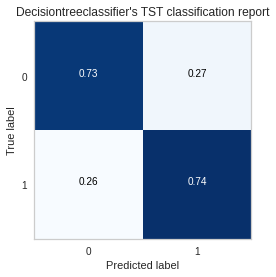

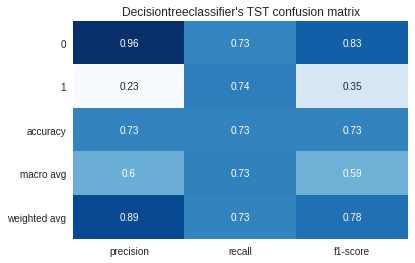

<Figure size 576x360 with 0 Axes>

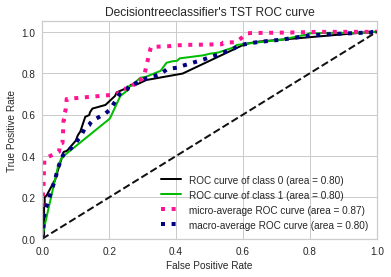

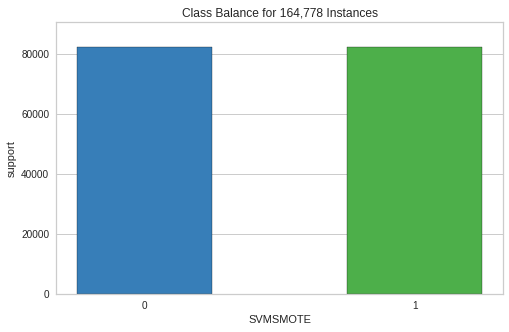

In [209]:
svm_smote_params_vt, svm_smote_tuned_model_vt, svm_smote_y_pred_vt, svm_smote_y_prob_vt, \
                            svm_smote_best_features_vt = imbalanced_grid_search(
                                                                           X_tr=X_tr_vt, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts_vt, 
                                                                           y_ts=y_ts, 
                                                                           grid=svm_smote_grid(X_tr_vt, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

<h2>ADASYN (Adaptive Synthetic Sampling)</h2>

Another approach involves generating synthetic samples inversely proportional to the density
of the examples in the minority class. That is, generate more synthetic examples in regions of
the feature space where the density of minority examples is low, and fewer or none where the
density is high. This modification to SMOTE is referred to as the Adaptive Synthetic Sampling
Method, or ADASYN.

<font color="green">PROS: With Borderline-SMOTE, a discriminative model is not created. Instead, examples in the
minority class are weighted according to their density, then those examples with the lowest
density are the focus for the SMOTE synthetic example generation process.
</font>

**Default parameters**:
- sampling_strategy='auto',   # resample all classes but the majority class
- random_state=None, 
- n_neighbors=5, 
- n_jobs=None


**Tuned parameters**:
- sampling_strategy = np.arange(0.1, 1.1, 0.1)*  
- random_state=42, 
- n_neighbors= range(1, sqrt(n_records)*2), 
- n_jobs=None

*number of samples in the minority class after resampling / number of samples in the majority class => desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling

In [210]:
def adasyn_grid(X_tr, y_tr):
    grid = model_grid(X_tr)
    sqrt_records = round(math.sqrt(X_tr.shape[0])) 
    grid['imbalancer__n_neighbors'] = list(range(1, sqrt_records*2))
    grid['imbalancer__sampling_strategy'] = list(np.arange(0.1, 1.1, 0.1))
    return grid

In [211]:
imbalancer_name = 'ADASYN'
imbalancer = ADASYN(random_state=random_state, n_jobs=None)

<h6>Plain model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.814 
Best Config: {'scaler': StandardScaler(), 'model__min_samples_split': 90, 'model__min_samples_leaf': 90, 'model__max_features': 'log2', 'model__max_depth': 29, 'model__criterion': 'entropy', 'model__class_weight': None, 'imbalancer__sampling_strategy': 0.2, 'imbalancer__n_neighbors': 383} 


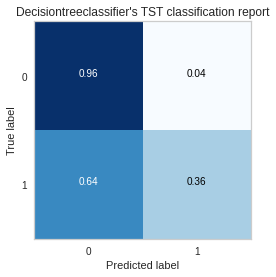

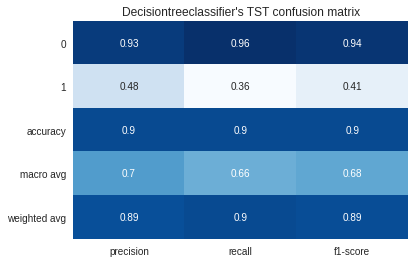

<Figure size 576x360 with 0 Axes>

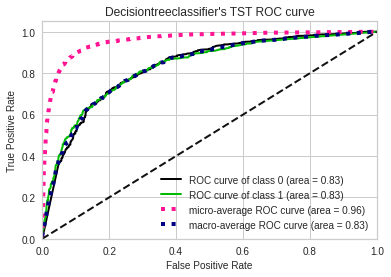

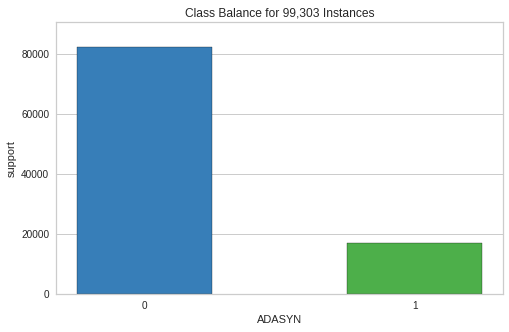

In [212]:
adasyn_params, adasyn_tuned_model, adasyn_y_pred, adasyn_y_prob, adasyn_best_features = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=adasyn_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

<h6>ANOVA model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.722 
Best Config: {'scaler': MaxAbsScaler(), 'model__min_samples_split': 50, 'model__min_samples_leaf': 90, 'model__max_features': 'sqrt', 'model__max_depth': 42, 'model__criterion': 'entropy', 'model__class_weight': 'balanced', 'imbalancer__sampling_strategy': 0.8, 'imbalancer__n_neighbors': 327, 'anova__k': 53} 


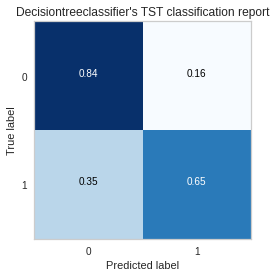

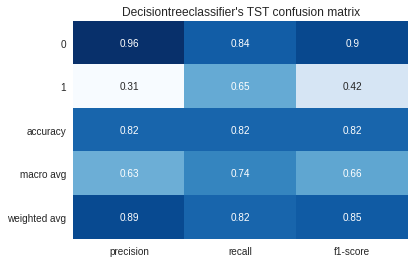

<Figure size 576x360 with 0 Axes>

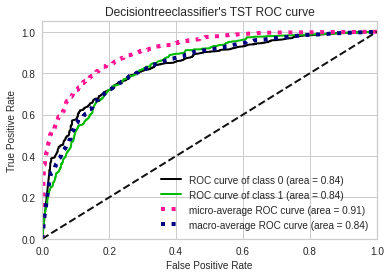

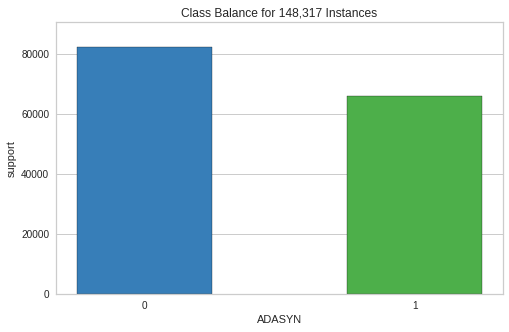

In [213]:
adasyn_params_anova, adasyn_tuned_model_anova, adasyn_y_pred_anova, adasyn_y_prob_anova, \
                                        adasyn_best_features_anova = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=adasyn_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="anova", 
                                                                           feature_flag=True)

<h6>RFE model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/alexandra/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 240, in _fit
    **fit_params_steps[name]
  File "/home/alexandra/.local/lib/python3.6/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/alexandra/.local/lib/python3.6/site-packages/imblearn/pipeline.py", line 403, in _fit_resample_one
    X_res, y_res = sampler.f

Best Mean F1_weighted: 0.681 
Best Config: {'scaler': MinMaxScaler(), 'rfe__n_features_to_select': 24, 'rfe__estimator': DecisionTreeClassifier(), 'model__min_samples_split': 80, 'model__min_samples_leaf': 20, 'model__max_features': 'auto', 'model__max_depth': 4, 'model__criterion': 'gini', 'model__class_weight': 'balanced', 'imbalancer__sampling_strategy': 0.4, 'imbalancer__n_neighbors': 160} 


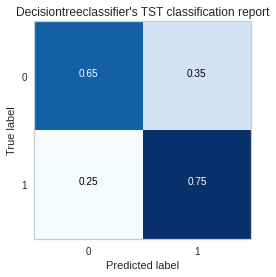

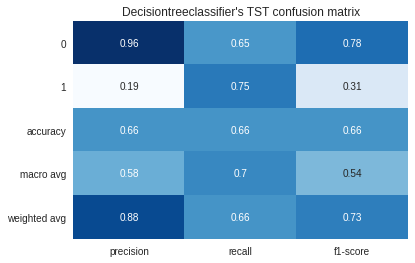

<Figure size 576x360 with 0 Axes>

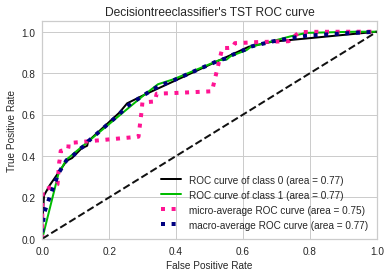

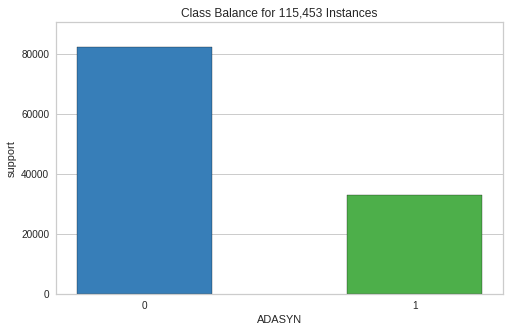

In [214]:
adasyn_params_rfe, adasyn_tuned_model_rfe, adasyn_y_pred_rfe, adasyn_y_prob_rfe, \
                        adasyn_best_features_rfe = imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=adasyn_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="rfe", 
                                                                           feature_flag=True)

<h6>VarianceThreshold model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.780 
Best Config: {'scaler': StandardScaler(), 'model__min_samples_split': 70, 'model__min_samples_leaf': 40, 'model__max_features': 'log2', 'model__max_depth': 11, 'model__criterion': 'entropy', 'model__class_weight': None, 'imbalancer__sampling_strategy': 0.7000000000000001, 'imbalancer__n_neighbors': 251} 


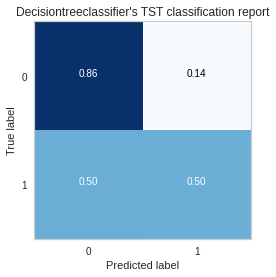

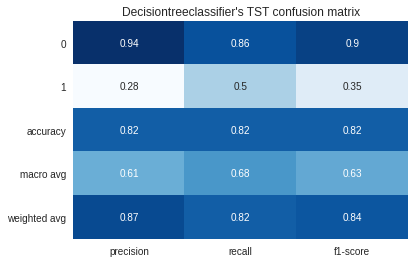

<Figure size 576x360 with 0 Axes>

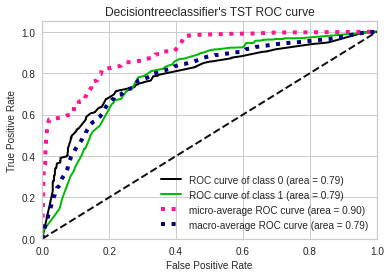

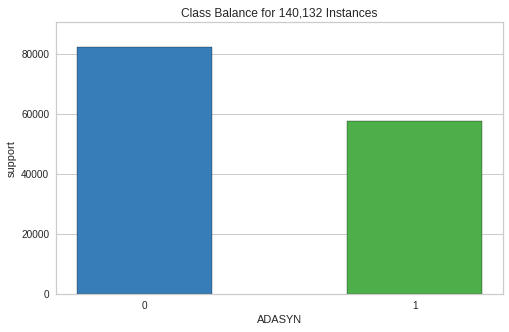

In [215]:
adasyn_params_vt, adasyn_tuned_model_vt, adasyn_y_pred_vt, adasyn_y_prob_vt, \
                            adasyn_best_features_vt = imbalanced_grid_search(
                                                                           X_tr=X_tr_vt, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts_vt, 
                                                                           y_ts=y_ts, 
                                                                           grid=adasyn_grid(X_tr_vt, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

In [216]:
sys.exit(-1)
trials_flag = False

SystemExit: -1

/home/alexandra/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<h2> Test curves </h2>

In [60]:
def draw_multiple_roc_curves(global_info, model_names, sampler_name, v_or_t_flag):
    # draw_roc_auc
    plt.figure(figsize=(8, 5))
    fprs = []
    tprs = []
    labels = []
    for model_name in global_info.keys():
        fpr = global_info[str(model_name)]["fpr"]
        tpr = global_info[str(model_name)]["tpr"]
        roc_auc = global_info[str(model_name)]["roc"] 
        label = '%s model=%0.4f' % (model_name, roc_auc)
        
        fprs.append(fpr)
        tprs.append(tpr)
        labels.append(label)
    
        # plt.plot(fpr, tpr, label='%s model=%0.4f' % (model_name, roc_auc))
        plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--', color="k", label='No-skilled model=0.5000') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="lower right", title="Weighted AUC", frameon=True)
    plt.title("%s' %s %s ROC-curve" % (model_names, v_or_t_flag, sampler_name))
    plt.show()

In [35]:
from sklearn.metrics import auc, roc_curve, roc_auc_score 

def get_roc_curve_and_roc_auc_score(y_tst, y_prd, curr_model_name, global_info):
    fpr, tpr, thresholds = roc_curve(y_tst, y_prd)
    roc = roc_auc_score(y_tst, y_prd, average="weighted")
    
    global_info[str(curr_model_name)]["fpr"] = fpr
    global_info[str(curr_model_name)]["tpr"] = tpr
    global_info[str(curr_model_name)]["roc"] = roc
    
    return global_info

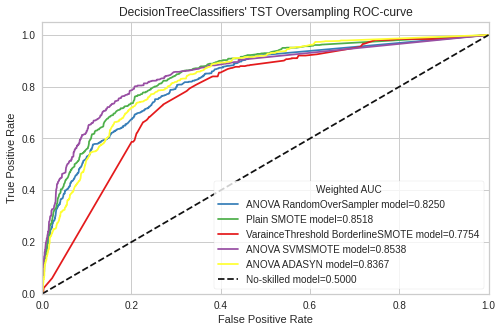

In [238]:
global_info = {}
global_info["ANOVA RandomOverSampler"] = {}
global_info["Plain SMOTE"] = {}
global_info["VarainceThreshold BorderlineSMOTE"] = {}
global_info["ANOVA SVMSMOTE"] = {}
global_info["ANOVA ADASYN"] = {}


global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), random_oversampler_y_prob_anova[:, 1], 
                                                                        "ANOVA RandomOverSampler", global_info)
global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), smote_y_prob[:, 1],
                                                                        "Plain SMOTE", global_info)
global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), borderline_smote_y_prob_vt[:, 1], 
                                                                "VarainceThreshold BorderlineSMOTE", global_info)
global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), svm_smote_y_prob_anova[:, 1], 
                                                                            "ANOVA SVMSMOTE", global_info)
global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), adasyn_y_prob_anova[:, 1], 
                                                                            "ANOVA ADASYN", global_info)

draw_multiple_roc_curves(global_info, model_name + "s", "Oversampling", v_or_t_flag)

<h2>Learning curve </h2>

This plotting is done at the end of the notebook, beacuse for some reason yellowbrick library overwrite scikitplot.

In [32]:
def plot_learning_curve(X_tr, y_tr, model, v_or_t_flag):
    second_score = ""
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
        second_score = "Validation score"
    else:
        cv = StratifiedKFold(n_splits=test_n_splits)
        second_score = "Test score"
       
    my_title = model_name + "'s %s Learning curve" % v_or_t_flag
        
    sizes = np.linspace(0.3, 1.0, 10)
    plt.figure(figsize=(8, 5))
    visualizer = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, 
                                                    n_jobs=None, random_state=random_state, title=my_title)

    visualizer.fit(X_tr, y_tr.values.ravel())    
    # visualizer.ax.get_lines()[1].set_label(second_score)
    visualizer.show() 
    
    # visualizer.set_title(model_name + "'s %s Learning curve" % v_or_t_flag)

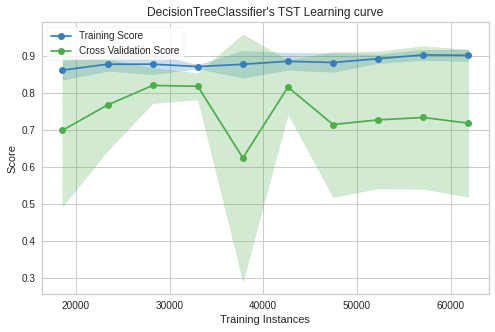

In [263]:
plot_learning_curve(X_tr, 
                    y_tr, 
                    svm_smote_tuned_model_anova, 
                    v_or_t_flag)

<h6> Saving best model on file </h6>

In [265]:
import pickle

model_info = {'params': svm_smote_params_anova,
              'tuned_model': svm_smote_tuned_model_anova,
              'y_pred': svm_smote_y_pred_anova,
              'y_prob': svm_smote_y_prob_anova,
              'best_features': svm_smote_best_features_anova,
              # 'best_features_scores': svm_smote_best_features_score_anova
             }

with open('pickle' + model_name + '_svm_smote_anova.pickle', 'wb') as handle:
    pickle.dump(model_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

<h2>Undersampling test curves</h2>

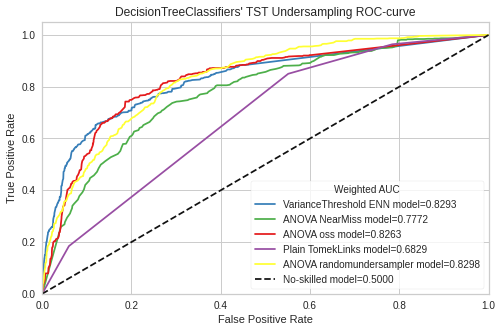

In [65]:
import os
import pickle

global_info = {}
pickle_dir_files = os.listdir('pickle/')
for filename in pickle_dir_files:
    if 'svmsmote' not in filename:
        with open('pickle/' + filename, 'rb') as handle:
            undersampling = pickle.load(handle)
            
            y_prob = undersampling['y_prob'] 
            m = filename.split("_")[1]
            if m == "enn":
                m = "ENN"
            elif m == "nearmiss":
                m = "NearMiss"
            elif m == "tomeklinks":
                m = "TomekLinks"
            elif m == "randomundersampler":
                m == "RandomUnderSampler"
            elif m == "oss":
                m == "OSS"
            else:
                sys.exit(-1)
            model_name = undersampling['model_name'] + " " + m
            
            global_info[model_name] = {}
            global_info = get_roc_curve_and_roc_auc_score(y_test.values.ravel(), y_prob[:, 1], 
                                                                            model_name, global_info)

draw_multiple_roc_curves(global_info,  "DecisionTreeClassifiers" , "Undersampling", v_or_t_flag)